# 2장 자연어와 단어의 분산 표현

시소러스는 유의어 사전, '뜻이 같은 단어(동의어)'나 '뜻이 비슷한 단어(유의어)'가 한 그룹으로 분류되어 있음.

In [1]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [2]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [3]:
word_to_id = {}

for word in words:
    if word not in word_to_id:
        new_id =  len(word_to_id)
        word_to_id[word] = new_id
        
id_to_word = {id_: word for word, id_ in word_to_id.items()}

In [4]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [5]:
id_to_word[1]

'say'

In [6]:
import numpy as np

corpus = [word_to_id[word] for word in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/Cola/')

In [15]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [16]:
import sys
sys.path.append('..')
from common.util import *

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [17]:
corpus, word_to_id, id_to_word

(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [18]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i  # left window_size
            right_idx = idx + i  # right window_size

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [20]:
def cos_similarity(x, y, eps=1e-8):
    # epsilon 값을 추가해, 
    # 0으로 나누기 오류가 나는 것을 막아줌
    nx = x / np.sqrt(np.sum(x**2) + eps)  # x의 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps)  # y의 정규화
    return np.dot(nx, ny)

In [21]:
window_size = 1
vocab_size = len(id_to_word)

C = create_co_matrix(corpus, vocab_size, window_size=1)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [23]:
import sys
sys.path.append('..')
from common.util import *

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  # "you"의 단어 벡터
c1 = C[word_to_id['i']]  # 'i'의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067758832467


In [25]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1) 검색어를 꺼낸다.
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return 
    
    print(f'\n[query] {query}')
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2) 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3) 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(f' {id_to_word[i]}: {similarity[i]}')
        
        count +=1
        if count >= top:
            return

In [26]:
import sys
sys.path.append('..')
from common.util import *

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


In [28]:
def ppmi(C, verbose=False, eps=1e-8):
    '''PPMI(점별 상호정보량) 생성
    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return: ppmi
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)  # num of corpus
    S = np.sum(C, axis=0)  # 각 단어의 출현 횟수
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[i]*S[j]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print(f'{(100*cnt/total):.2f} 완료')
    return M

In [29]:
import sys
sys.path.append('..')
import numpy as np
from common.util import *

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('Co-occurrence Matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-occurrence Matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [31]:
from common.util import *
most_similar('you', word_to_id, id_to_word, W, top=5)


[query] you
 goodbye: 0.40786147117614746
 i: 0.40786147117614746
 hello: 0.2763834297657013
 say: 0.0
 and: 0.0


In [33]:
%matplotlib inline
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import *


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

In [34]:
print(C[0])  
print(W[0])  
print(U[0])  

print(U[0, :2])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[-1.110e-16  3.409e-01 -4.163e-16 -1.205e-01 -1.110e-16 -9.323e-01
 -1.086e-16]
[-1.110e-16  3.409e-01]


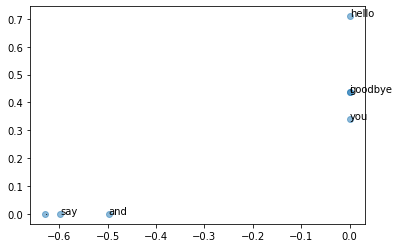

In [35]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [44]:
from common import *

In [49]:
import sys
sys.path.append('..')
from common.dataset import *


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

ModuleNotFoundError: ignored